# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно определить рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

Прежде, чем приступать к работе, наметим план.
В первую очередь, прочитав и изучив предоставленный архив, необходимо произвести предобработку данных (проверить дубликаты, пропущенные значения, выбросы данных).
Добавить в датафрейм дополнительные столбцы, которые помогут при анализе.
Проверить скорость продажи квартир, а также определить различные факторы, влияющие на стоимость (и вообще,  понять, есть ли зависимость между различными параметрами).

## Откройте файл с данными и изучите общую информацию

In [146]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [147]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

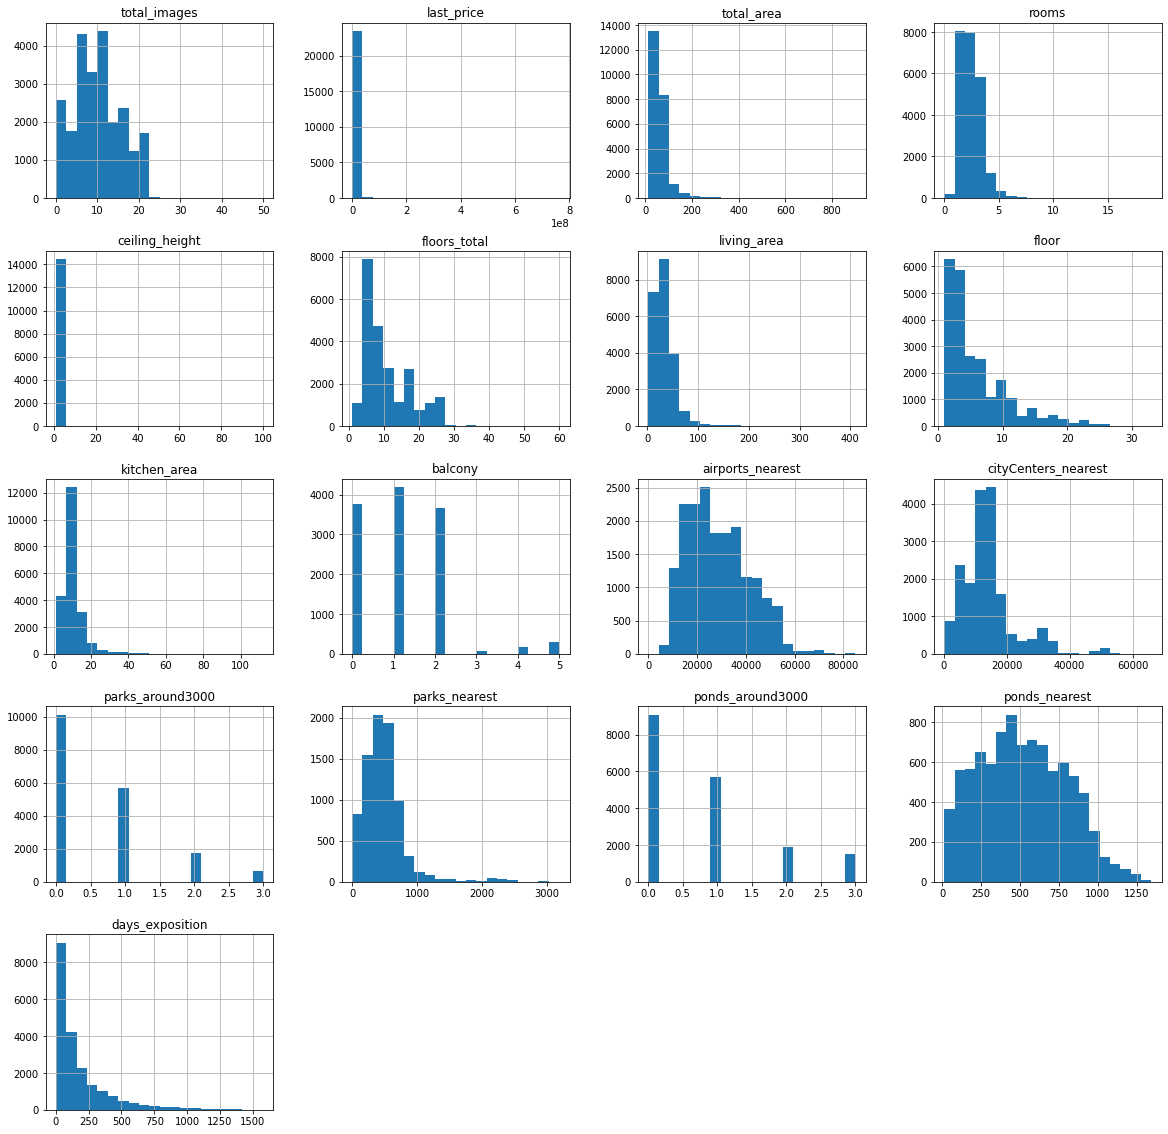

In [148]:
data.hist(bins=20, figsize=(20, 20))

## Выполните предобработку данных

In [149]:
data.isna().sum() #находим количество пропущенных значений в каждом столбце

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Обработка пропущенных значений

**В столбце `is_apartment` пропущенные значения можем заменить на значения 'False', т.к. там где они не указаны, значит, что это не апартаменты.
После этого необходимо заменить тип данных с 'object' на 'bool'**

In [150]:
data['is_apartment'] = data['is_apartment'].fillna(False) #заполняем пустые значения
data['is_apartment'] = data['is_apartment'].astype('bool') # меняем тип данных

**В столбце `balcony` пропущенные значения можем заменить на значения '0', т.к. там где они не указаны, значит, что квартира без балкона**

In [151]:
data['balcony'] = data['balcony'].fillna(0) 
data['balcony'].unique() # проверим уникальные значения в столбце

array([0., 2., 1., 5., 4., 3.])

**Изменим тип данных в столбце `balcony`, т.к. количество балконов может быть только целым числом**

In [152]:
data['balcony'] = data['balcony'].astype(int) # изменяем тип данных на int
data['balcony'].unique() # проверим уникальные значения в столбце

array([0, 2, 1, 5, 4, 3])

**Изучим столбец `locality_name`**

In [153]:
data['locality_name'].unique() # найдем все уникальные значения

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

**В столбце присутствуют явные дубликаты. При указания поселков были применены разные обозначения типа поселков (например, поселок и поселок городского типа), но названия поселков при этом одинаковы, а также одни и те же названия в одних случаях  пишутся с "е", в других с "ё". Устраним эти дубликаты**

In [154]:
# воспользуемся методом replace() для замены значений внутри столбца
data['locality_name'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок городского типа', 'городской поселок'], 'поселок', regex=True)
)

**Пропущенные значения никак не заполним и их очень мало, поэтому принимаем решение об удалении строк,
где имеются пропуски в столбце `locality_name`**

In [155]:
data = data.dropna(subset=['locality_name']) # удаляем строки со значением NaN

**Пропущенные значения `floors_total` никак не заполним и их очень мало, поэтому принимаем решение об удалении строк c пропусками в этом столбце**

In [156]:
data = data.dropna(subset=['floors_total']) # удаляем строки со значением NaN

**Перевод строк для столбца `first_day_exposition` в дату и время**

In [157]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [158]:
# проверим теперь, в каких строках имеются пропущенные данные
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

**Вывод: в столбцах, где это возможно заполнили пропущенные значения (является ли квартира апартаментами, количество балконов, количество парков и водоемов в радиусе 3 км), а также изменили тип данных на более подходящий 
(для целочисленных значений нет смысла указывать дробные величины), обработали явные дубликаты и удалили строки с пропусками в столбце с названиями местоположения продаваемых квартир, которые не повлияют на основное исследование. Также столбец с датой публикации был переведен в дату и время для удобства извлечений данных (день, месяц, год публикации) и проведения анализа в дальнейшем.**

## Добавьте в таблицу новые столбцы

**Для решения поставленной задачи необходимо в таблицу добавить новые столбцы:**
- цена одного квадратного метра;
- день недели публикации объявления;
- месяц публикации объявления;
- год публикации объявления;
- тип этажа квартиры;
- расстояние до центра города в километрах.

### Цена одного квадратного метра

In [159]:
# разделим стоимость объекта на его площадь и округлим результат до сотых
data['price_1m2'] = round(data['last_price'] / data['total_area'], 2)

### День недели публикации объявления

Дни недели будут указаны числами от 0 до 6, начиная с понедельника

In [160]:
data['day_of_piblication_nmb'] = data['first_day_exposition'].dt.weekday 

Создадим таблицу с помощью метода apply() с указанием названия дня недели, соответствующего номеру (от 0 до 6 - от понедельника до воскресенья)

In [161]:
def day_of_week(row):
    if row == 0:
        return 'Понедельник'
    elif row == 1:
        return 'Вторник'
    elif row == 2:
        return 'Среда'
    elif row == 3:
        return 'Четверг'
    elif row == 4:
        return 'Пятница'
    elif row == 5:
        return 'Суббота'
    else:
        return 'Воскресенье'
# создаем новый столбец, применив apply() с аргументом функции, а на вход поступают данные 
# а на вход поступают данные из столбца 'day_of_piblication_nmb'
data['day_of_piblication'] = data['day_of_piblication_nmb'].apply(day_of_week)

### Месяц публикации объявления

In [162]:
data['month_of_piblication_nmb'] = data['first_day_exposition'].dt.month
data['month_of_piblication_nmb'].unique()

array([ 3, 12,  8,  7,  6,  9, 11,  4,  5,  2,  1, 10])

Создадим таблицу с помощью метода apply() с указанием названия месяца, соответствующего номеру.

In [163]:
def month_of_publication(row):
    if row == 1:
        return 'Январь'
    elif row == 2:
        return 'Февраль'
    elif row == 3:
        return 'Март'
    elif row == 4:
        return 'Апрель'
    elif row == 5:
        return 'Май'
    elif row == 6:
        return 'Июнь'
    elif row == 7:
        return 'Июль'
    elif row == 8:
        return 'Август'
    elif row == 9:
        return 'Сентябрь'
    elif row == 10:
        return 'Октябрь'
    elif row == 11:
        return 'Ноябрь'
    else:
        return 'Декабрь'
        
data['month_of_piblication'] = data['month_of_piblication_nmb'].apply(month_of_publication)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_1m2,day_of_piblication_nmb,day_of_piblication,month_of_piblication_nmb,month_of_piblication
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.37,3,Четверг,3,Март
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82920.79,1,Вторник,12,Декабрь
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.71,3,Четверг,8,Август
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.10,4,Пятница,7,Июль
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000.00,1,Вторник,6,Июнь


### Год публикации объявления

In [164]:
data['year_of_piblication'] = data['first_day_exposition'].dt.year

### Тип этажа квартиры

В новом столбце `floor_type` должны быть следующие значения: «первый», «последний», «другой».
Значение «первый» будет, если строка в столбце `floor` равна 1.
Значение «последний» - если строки в столбцах `floor` и `floors_total`равны.
Во всех остальных случаях - «другой».
Воспользуемся методом apply() для формирования нового столбца по данным из существующего.

In [165]:
def floor_type_func(row): # создаем функцию с аргументом строки в датафрейме
    if row['floor'] == 1: # условие для первого этажа
        return 'первый'
    elif row['floor'] == row['floors_total']: # условие для последнего этажа
        return 'последний'
    else:
        return 'другой'
# создаем новый столбец и помещаем в него данные методом apply
# т.к. нам нужны данные из нескольких столбцов метод вызываем ко всему датафрейму
# чтобы перебрать все строки без цикла apply() принимает параметр axis=1
data['floor_type'] = data.apply(floor_type_func, axis=1)
data.head() # проверим наличие нового столбца

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_1m2,day_of_piblication_nmb,day_of_piblication,month_of_piblication_nmb,month_of_piblication,year_of_piblication,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,NaN,120370.37,3,Четверг,3,Март,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,0.0,NaN,81.0,82920.79,1,Вторник,12,Декабрь,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,2.0,574.0,558.0,92785.71,3,Четверг,8,Август,2015,другой
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,3.0,234.0,424.0,408176.10,4,Пятница,7,Июль,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,100000.00,1,Вторник,6,Июнь,2018,другой


### Расстояние до центра города в километрах

In [166]:
data['cityCenters_nearest_km'] = round(data['cityCenters_nearest'] / 1000)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,price_1m2,day_of_piblication_nmb,day_of_piblication,month_of_piblication_nmb,month_of_piblication,year_of_piblication,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,755.0,NaN,120370.37,3,Четверг,3,Март,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,...,NaN,81.0,82920.79,1,Вторник,12,Декабрь,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,...,574.0,558.0,92785.71,3,Четверг,8,Август,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,...,234.0,424.0,408176.10,4,Пятница,7,Июль,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,48.0,121.0,100000.00,1,Вторник,6,Июнь,2018,другой,8.0


## Проведите исследовательский анализ данных

### Изучение параметров объектов

#### Общая площадь

<AxesSubplot:>

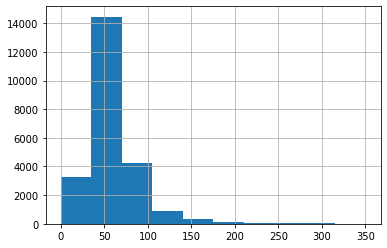

In [167]:
data['total_area'].hist(range=(0, 350))

**Судя по гистограмме, большая часть квартир продается площадью в районе 50 кв.м., основная масса квартир площадью
до 100 кв.м., от 170 до 310 кв.м. - единицы квартир**

#### Жилая площадь

<AxesSubplot:>

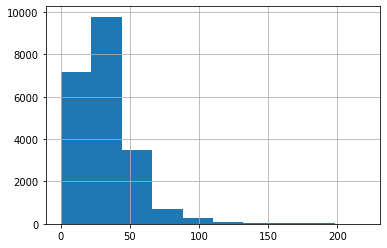

In [168]:
data['living_area'].hist(range=(0, 220))

**Графики общей площади и жилой площади должны совпадать с небольшим сдвигом влево, т.к. жилая площадь должна быть меньше общей площади. Таким образом, делаем вывод, что данные в корректны, а также в продаже большинство объектов до 50 кв.м. жилой площадью.**

#### Площадь кухни

<AxesSubplot:>

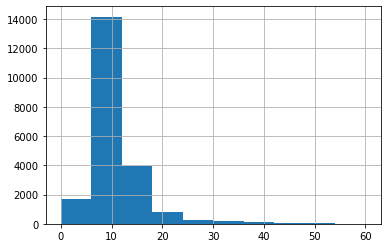

In [169]:
data['kitchen_area'].hist(range=(0, 60))

**Большинство продаваемых объектов с кухней 10 кв.м., а объектов с площадью больше 55 кв.м. нет в продаже. Если Вы хотите купить квартиру с площадью кухни от 23 кв.м., Вы должны понимать, что таких объектов на рынке недвижимости очень мало.**

#### Цена объекта

Посмотрим, какие данные находятся в графе цена методом describe()

In [170]:
data['last_price'].describe() 

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Минимальное и максимальное значения похожи на выбросы.
Проверим, какая цена для самых дешевых объектов

In [171]:
data = data.sort_values(by='last_price')
data['last_price'].head(10)

8793      12190.0
17456    430000.0
14911    430000.0
16274    440000.0
9581     450000.0
17676    450000.0
16219    450000.0
5698     450000.0
18867    470000.0
23484    470000.0
Name: last_price, dtype: float64

Цена квартиры 12190 будем считать выбросом и минимальное значение для цены примем 430000.
Также видно, что максимальное значение сильно выбивается. 
Построим диаграмму размаха в диапазонах от 430тыс до 20млн

(430000.0, 20000000.0)

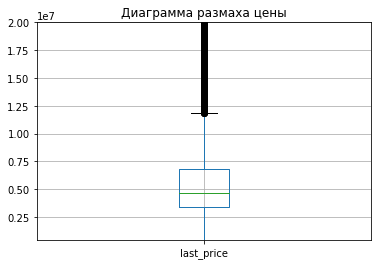

In [172]:
data.boxplot('last_price')
plt.title('Диаграмма размаха цены')
plt.ylim(4.3e+05, 2e+07)

Отбросим значения меньше 430тыс и больше 12млн методом query()

In [173]:
data_opt_price = data.query('430000 < last_price < 12000000')

Проверим, какая доля данных от начального числа осталась для исследования, используя DataFrame.shape

In [174]:
shape_data = data.shape # получаем количество строк и столбцов в первоначальном датафрейме
shape_data_opt_price = data_opt_price.shape # получаем количество строк и столбцов в отфильтрованном датафрейме

shape_data_opt_price[0] / shape_data[0] # интересуют только строки

0.9157224697644812

Т.к. мы оставили более 90% данных, то это не вредит на актуальность полученных данных

Теперь по этим данным построим гистограмму

<AxesSubplot:>

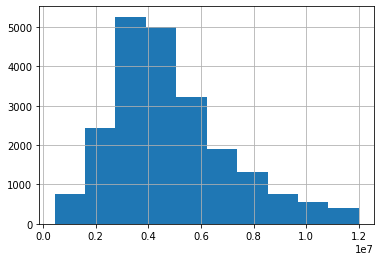

In [175]:
data_opt_price['last_price'].hist()

**Судя по гистограмме большинство объектов продается по цене в районе 4 млн руб, что соответствует тому, что большинство объектов с квадратурой 50 кв.м. (средние квартиры), а очень дорогих квартир гораздо меньше, также как и квартир с большой площадью.**

#### Количество комнат

<AxesSubplot:>

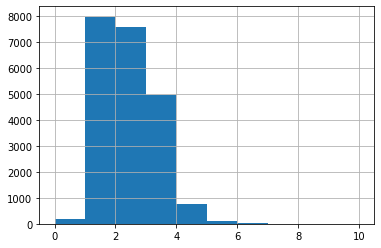

In [176]:
data_opt_price['rooms'].hist(range=(0, 10))

**Количество комнат 0 говорит о том, что это квартиры-студии, их очень мало в продаже также как и объектов с количеством комнат более 5, основная же масса продаваемых объектов - однокомнатные и двухкомнатные квартиры, что соответствует наиболее популярной общей площади квартир 50 кв.м.**

#### Высота потолков

<AxesSubplot:>

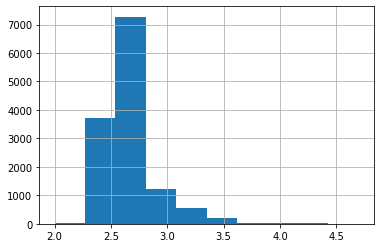

In [177]:
data_opt_price['ceiling_height'].hist(range=(2, 4.7))

**Высота потолков в основном 2.75м, но также много квартир с высотой потолков 2.5м, а высоких квартир не так много.**

#### Тип этажа

<AxesSubplot:>

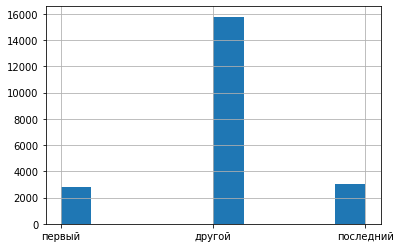

In [178]:
data_opt_price['floor_type'].hist()

**Объекты есть на всех этажах, включая первый и последний, но между ними значительно больше.**

#### Oбщее количество этажей в доме

<AxesSubplot:>

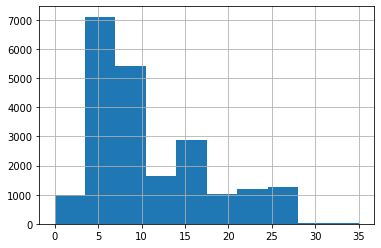

In [179]:
data_opt_price['floors_total'].hist(range=(0, 35))

**Большинство объектов на рынке недвижимости находится в пятиэтажных домах, а также в девятиэтажных**

#### Расстояние до центра города в метрах

<AxesSubplot:>

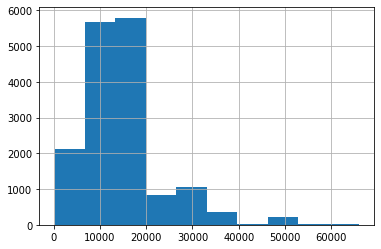

In [180]:
data_opt_price['cityCenters_nearest'].hist()

Большинство объектов находится в радиусе 8-20 км. Посмотрим подлиже этот диапазон

<AxesSubplot:>

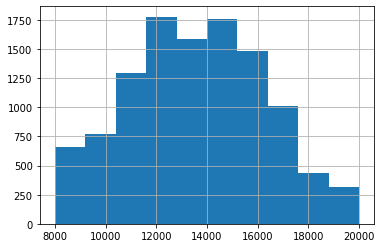

In [181]:
data_opt_price['cityCenters_nearest'].hist(range=(8000, 20000))

**Большинство объектов находится на расстоянии 12-15 км от центра города**

#### Расстояние до ближайшего парка

<AxesSubplot:>

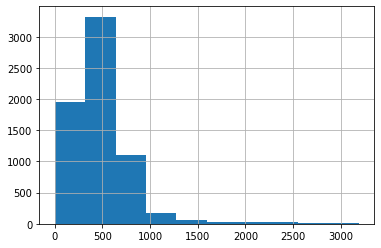

In [182]:
data_opt_price['parks_nearest'].hist()

**Большинство объектов находится вблизи парков в районе 500м и меньше.**

### Скорость продажи квартиры

Изучим данные в столбце `days_exposition`

In [183]:
data_opt_price['days_exposition'].describe()

count    18944.000000
mean       173.365287
std        211.958654
min          1.000000
25%         44.000000
50%         91.000000
75%        219.000000
max       1580.000000
Name: days_exposition, dtype: float64

Минимальное значение продажи квартиры - 1 день, максимальное - критично долго 1580 дней, это больше четырех лет. 
Думаю, это слишком долго и нестандартная ситуация для тех, кто хочет продать в короткие сроки. 
Стандартное отклоненение достаточно большое - 211 дней, что говорит о большом разбросе данных, поэтому и такое большое отличие между средним значением (173 дня) и медианой (91 день). Т.к. медиана не учитывает выбросы в большую или меньшую сторону, то она является более объективной оценкой для определения среднестатистического срока продажи объекта недвижимости.

Построим диаграмму размаха по этим данным

Text(0.5, 1.0, 'Диаграмма размаха срока продажи квартир')

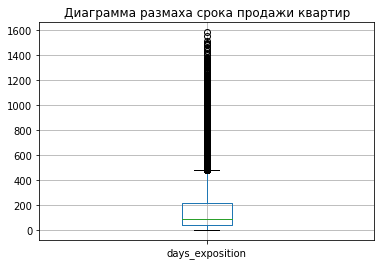

In [184]:
data_opt_price.boxplot('days_exposition')
plt.title('Диаграмма размаха срока продажи квартир')

Видно, что 500 дней, это выбросы. Исключим их из общих данных.

In [185]:
data_opt_price_exp = data_opt_price.query('days_exposition < 500')

<AxesSubplot:>

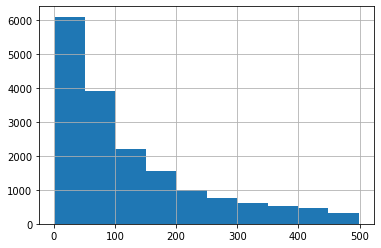

In [186]:
data_opt_price_exp['days_exposition'].hist()

Интересно, какая картина в первые 100 дней продажи. Построим еще одну гистограмму в диапазоне до 100 дней

<AxesSubplot:>

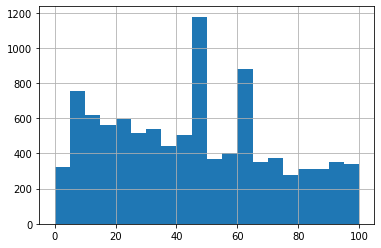

In [187]:
data_opt_price_exp['days_exposition'].hist(bins=20, range=(0, 100))

**Вывод:** 

**Самое популярное время продажи квартир 50 дней (созрел слоган "гарантируем продажу Вашей 50-тиквадратной квартиры за 50 дней"), экстремально быстрыми продажами можно считать сроки до 10 дней включительно, а необычно долгие продажи я бы посчитала те, что входят в диаграмму размаха и занимают 25% всех продаж, более 219 дней, а экстремально долгие, на которые я бы не рекомендовала опираться - от 500 дней.**

### Определение факторов, которые больше всего влияют на общую стоимость объекта

#### Зависимость цены квартиры от общей площади

<AxesSubplot:xlabel='last_price', ylabel='total_area'>

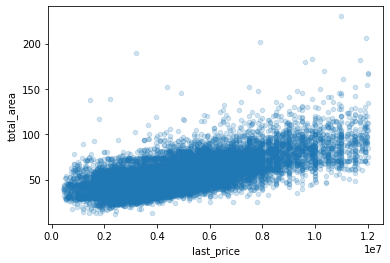

In [188]:
# построим диаграмму рассеивания зависимости оптимальной цены от общей площади
# параметром alpha сделаем точки полупрозрачными
data_opt_price_exp.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2) 

In [189]:
data_opt_price_exp['last_price'].corr(data_opt_price_exp['total_area']) #рассчитаем коэффициент корреляции Пирсона

0.7059067975411542

**График показывает и положительный коэффициент корреляции, близкий к единице, подтверждает наличие прямой  зависимости стоимости квартиры от ее общей площади, т.е. чем больше квартира, тем дороже она стоит.**

#### Зависимость цены квартиры от жилой площади

<AxesSubplot:xlabel='last_price', ylabel='living_area'>

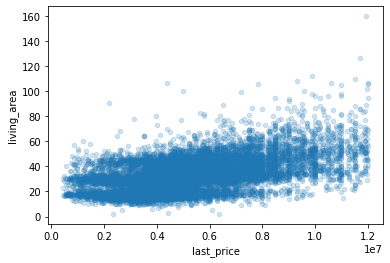

In [190]:
data_opt_price_exp.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)

In [191]:
data_opt_price_exp['last_price'].corr(data_opt_price_exp['living_area'])

0.5876862173782224

**График также показывает прямую зависимость между ценой и жилой площадью, но меньше, чем с общей площадью**

#### Зависимость цены квартиры от площади кухни

<AxesSubplot:xlabel='last_price', ylabel='kitchen_area'>

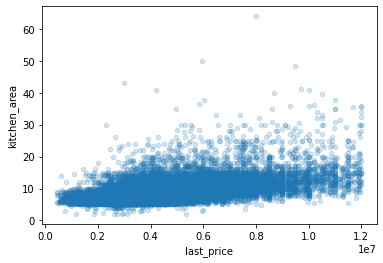

In [192]:
data_opt_price_exp.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2)

In [193]:
data_opt_price_exp['last_price'].corr(data_opt_price_exp['kitchen_area'])

0.48754410087883804

**По графику и значению коэффициента корреляции мы видим, что зависимость практически не прослеживается между размерами кухни и стоимостью. Квартиры могут быть без кухни или маленькой кухней, или кухня объеденена с жилой площадью квартиры, поэтому я бы не выделяла площадь кухни как параметр, влияющий на общую стоимость объекта.**

#### Зависимость цены квартиры от количества комнат

<AxesSubplot:xlabel='last_price', ylabel='rooms'>

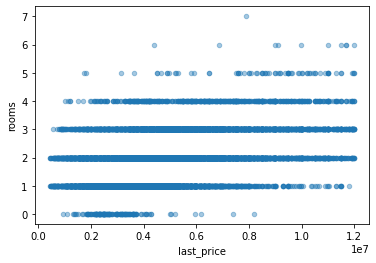

In [194]:
data_opt_price_exp.plot(x='last_price', y='rooms', kind='scatter', alpha=0.4)

По графику виднооднокомнатные дороже студий, двухкомнатные квартиры дороже однокомнатных, а дальше непонятно.
Предлагаю сравнить медианные значения стоимости квартир в зависимости от количества комнат. Исключим из этих данных семикомнатные квартиры, т.к. по ним слишком мало точек на графике.

<AxesSubplot:xlabel='rooms'>

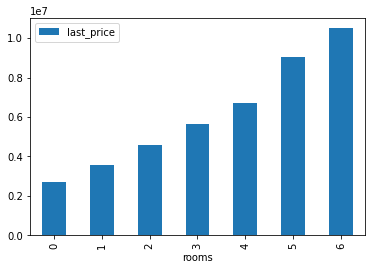

In [195]:
# помня о бритве Оккамы, не будем создавать для этой цели новую переменную
# методом query() уберем из графика семикомнатные квартиры и выше
# применим метод pivot_table для подсчета медианы общей стоимости в категории количества комнат
# типа графика выберем bar
(
    data_opt_price_exp
    .query('rooms < 7')
    .pivot_table(index='rooms', values='last_price', aggfunc='median')
    .plot(kind='bar')
)

**График наглядно показывает, чем больше количество комнат, тем выше цена (в нашем случае медианная)**

#### Зависимость цены квартиры от типа этажа

Также следует применить группировку по типу этажа и посчитать медианное значение цены в каждой категории

<AxesSubplot:xlabel='floor_type'>

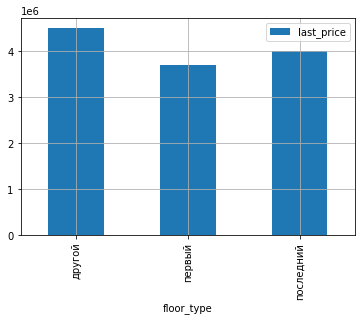

In [196]:
(
    data_opt_price_exp
    .pivot_table(index='floor_type', values='last_price', aggfunc='median')
    .plot(figsize=(6,4), kind='bar', grid=True)
)

**По графику видно, что самые дешевые квартиры находятся на первом этаже, также на последнем этаже квартиры дешевле по сравнению с другими этажами.**

#### Зависимость цены квартиры от даты размещения (день недели, месяц, год)

Зависимость цены квартиры от дня размещения

<AxesSubplot:xlabel='day_of_piblication'>

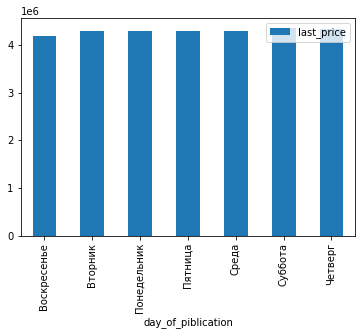

In [197]:
(
    data_opt_price_exp
    .pivot_table(index='day_of_piblication', values='last_price', aggfunc='median')
    .plot(kind='bar')
)

Зависимость цены квартиры от месяца размещения

<AxesSubplot:xlabel='month_of_piblication'>

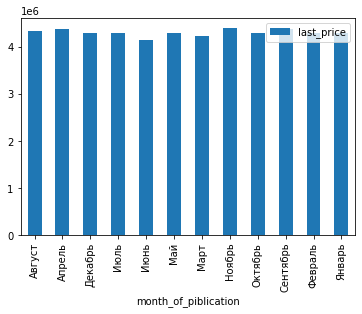

In [198]:
(
    data_opt_price_exp
    .pivot_table(index='month_of_piblication', values='last_price', aggfunc='median')
    .plot(kind='bar')
)

Зависимость цены квартиры от года размещения

<AxesSubplot:xlabel='year_of_piblication'>

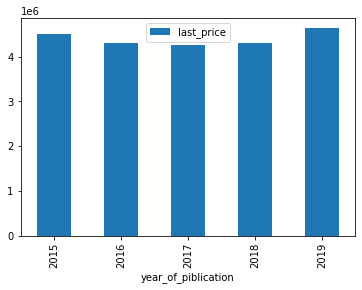

In [199]:
(
    data_opt_price_exp
    .pivot_table(index='year_of_piblication', values='last_price', aggfunc='median')
    .plot(kind='bar')
)

<div class="alert alert-block alert-info">
    
Ниже до вывода внесены новые расчеты
</div>

Прежде, чем делать вывод, проверим не уменьшилась ли площадь продаваемых квартир с течением времени

<AxesSubplot:xlabel='year_of_piblication'>

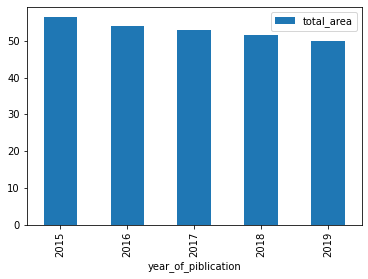

In [200]:
(
    data_opt_price_exp
    .pivot_table(index='year_of_piblication', values='total_area')
    .plot(kind='bar')
)

Действительно, с каждым последующим годом средняя площадь квартир падает, соответственно, такие квартиры дешевле, но при этом мы наблюдаем рост цен квартир, значит, квадратный метр - дорожает еще больше.

**Вывод: цена квартиры не зависит ни от дня недели размещения, ни от месяца, есть небольшие изменения в графиках, но мне кажется, они незначительны и не стоит ждать, например, ноября, чтобы дороже продать квартиру, если Вы хотите продать ее весной. По годам мы видим по графику, что средняя стоимость квартир с 2015 года по 2017 год немного падала,но скорее всего это не связано с падением рынка недвижимости, а с тем, что с 2015 года наблюдается падение площади продаваемых квартир,  при этом площадь падает на протяжении вплоть до 2019 года, а с 2017 по 2019 начала цена растет, значит, стоимость квадратного метра значительно повышается.**

### Цена квартир в самых популярных населеных пунктах

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [201]:
# воспользуемся методом pivot_table для группировки по населенным пунктам
# посчитаем количество запросов и среднюю цену за квадратный метр
locality_price_m2 = data_opt_price_exp.pivot_table(index='locality_name', values ='price_1m2', \
                                                  aggfunc=['count', 'mean'])
# переименуем названия столбцов
locality_price_m2.columns = ['count', 'mean']
# отсортируем по количеству от наибольшего и выберем верхние десять
locality_price_m2 = locality_price_m2.sort_values(by='count', ascending=False).head(10)
locality_price_m2

,count,mean
locality_name,,
Санкт-Петербург,11212,104389.407151
поселок Мурино,513,85929.958070
поселок Шушары,384,77792.490208
Всеволожск,307,66743.025309
Колпино,291,74499.000756
поселок Парголово,287,89186.224425
деревня Кудрово,265,92585.904943
Пушкин,261,99218.029502
Гатчина,243,67974.620947


В таблице представлены населенные пункты, в которых наибольшее количество предложений о продаже квартир.
Санкт-Петербург сильно отличается на фоне пригородных населенных пунктов.

Построим диаграмму со средней ценой квартир в этих населенных пунктах.

<AxesSubplot:xlabel='locality_name'>

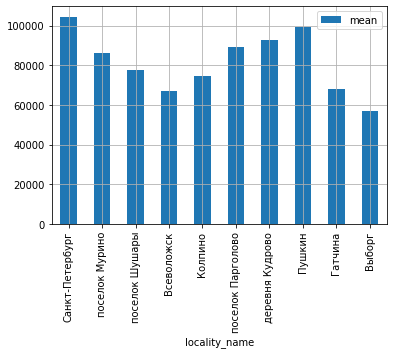

In [202]:
locality_price_m2.plot(y='mean', kind='bar', grid=True)

**Вывод: самый дорогой квадратный метр в Санкт-Петербурге, причем если его не брать в расчет, то среди пригорода Санкт-Петербурга лидирует Пушкин. А самая дешевая стоимость квадратного метра в Выборге.**

### Зависимость стоимости квартиры от удаленности от центра в Санкт-Петербурге

In [203]:
data_opt_price_exp['cityCenters_nearest_km'].unique()

array([nan, 11., 12., 14., 16., 21., 30.,  4., 50., 18., 41., 22., 60.,
       42.,  5., 17., 53.,  6., 15., 52., 33., 27., 31., 36., 24., 29.,
       23., 35.,  2., 32., 28.,  8., 19., 13.,  7., 37.,  9., 34., 20.,
        3., 10., 39.,  1., 49., 51., 47., 26., 25., 40., 48., 54., 61.,
       62., 63., 65., 59., 45.,  0., 43., 55.])

In [204]:
data_nearest = data_opt_price_exp.dropna(subset=['cityCenters_nearest_km'])
data_nearest['cityCenters_nearest_km'].unique()

array([11., 12., 14., 16., 21., 30.,  4., 50., 18., 41., 22., 60., 42.,
        5., 17., 53.,  6., 15., 52., 33., 27., 31., 36., 24., 29., 23.,
       35.,  2., 32., 28.,  8., 19., 13.,  7., 37.,  9., 34., 20.,  3.,
       10., 39.,  1., 49., 51., 47., 26., 25., 40., 48., 54., 61., 62.,
       63., 65., 59., 45.,  0., 43., 55.])

In [205]:
# выбираем только строки с населенным пунктом "Санкт-Петербург"
data_nearest_spb = data_nearest.query('locality_name == "Санкт-Петербург"')

<AxesSubplot:xlabel='cityCenters_nearest_km'>

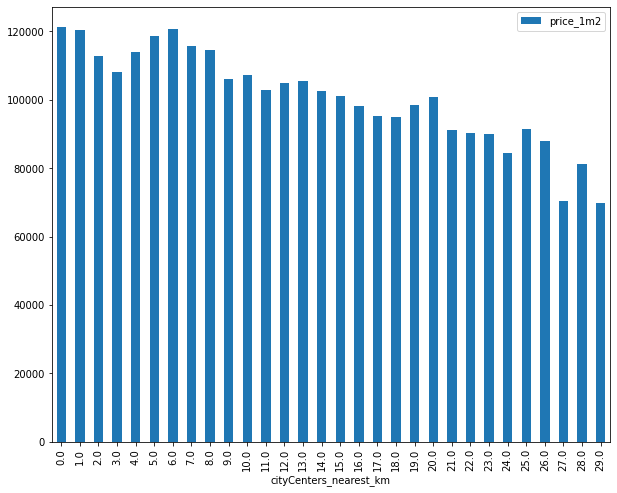

In [206]:
data_nearest_spb_grop = data_nearest_spb.pivot_table(index='cityCenters_nearest_km', values='price_1m2')
data_nearest_spb_grop.plot(y='price_1m2', kind='bar', figsize=(10, 8))

**Вывод: чем ближе к центру, тем стоимость квартиры растет. Самые дорогие квартиры в пределах 10 км от центра.**

## Общий вывод

Целью работы является определить показатели, влияющие на рыночную стоимость квартир и научиться ее определять.

Для анализа был взят архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 

Прежде чем анализировать различные показатели необходимо было провести **предобработку данных**. В первую очередь я обратила внимание на большое количество пропущенных данных, удалив строки с которыми могли бы получиться искаженные результаты, поэтому данные были заполнены там, где это возможно (предположила, что там, где не заполнены значения с *количеством балконов*, является ли квартира *апартаментами*, *количество водоемов и парков поблизости* - можно поставить значение "0"). В графе с *населенными пунктами* были замечены неявные дубликаты, которые были удалены ручным способом. Также были удалены строки с *выбросами данных* (слишком высокая и низкая цена, а также объекты с экстремально долгим сроком размещения (более 4 лет)).

Для определения различных параметров, влияющих на стоимость квартир, в таблицу были добавлены дополнитальные столбцы: 
- цена одного квадратного метра;
- день недели, месяц, год публикации;
- тип этажа квартиры (первый, последний или другой);
- расстояние до центра города.

Было изучено влияние следующих параметров на стоимость объектов недвижимости:
- общая площадь - большая часть квартир продается площадью в районе 50 кв.м., основная масса квартир площадью до 100 кв.м., от 170 до 310 кв.м. - единицы квартир;
- жилая площадь - продаже большинство объектов до 50 кв.м. жилой площадью;
- площадь кухни - большинство продаваемых объектов с кухней 10 кв.м., а объектов с площадью кухни больше 55 кв.м. нет в продаже;
- цена объекта - большинство объектов продается по цене в районе 4 млн руб, что соответствует тому, что большинство объектов с квадратурой 50 кв.м. (средние квартиры), а очень дорогих квартир гораздо меньше, также как и квартир с большой площадью;
- количество комнат - основная масса продаваемых объектов - однокомнатные и двухкомнатные квартиры, что соответствует наиболее популярной общей площади квартир 50 кв.м.;
- высота потолков - высота потолков в основном 2.75м, но также много квартир с высотой потолков 2.5м, а высоких квартир не так много;
- тип этажа - объекты есть на всех этажах, включая первый и последний, но между ними значительно больше;
- общее количество этажей в доме;
- расстояние до центра города - большинство объектов находится на расстоянии 12-15 км от центра города;
- расстояние до ближайшего парка - большинство объектов находится вблизи парков в районе 500м и меньше.

Был определен срок продажи квартир: самое популярное время продажи квартир 50 дней (созрел слоган "гарантируем продажу Вашей 50-тиквадратной квартиры за 50 дней"), экстремально быстрыми продажами можно считать сроки до 10 дней включительно, а необычно долгие продажи я бы посчитала те, что входят в диаграмму размаха и занимают 25% всех продаж, более 219 дней, а экстремально долгие, на которые я бы не рекомендовала опираться - от 500 дней.

Итак, наиболее значимые факторы, влияющие на стоимость квартиры:
- населенный пункт (квартиры в городе дороже, чем в пригороде, а также выбор во много раз больше) с хорошей инфраструктурой (к примеру, близость с парком) и как можно ближе к центру;
- общая площадь и количество комнат - чем больше квартира и больше в ней комнат, тем больше цена;
- тип этажа - самые дешевые квартиры на первом этаже, а также на последнем немного дороже, но все же дешевле промежуточных этажей.

По сравнению с вышеперечисленными следующие факторы не существенно влияют на стоимость квартиры:
- площадь кухни и жилая площадь;
- день и месяц размещения - не стоит ждать определенного дня и месяца, чтобы опубликовать объявление о продаже квартиры.

При этом год размещения объявления влияет на стоимость продажи, т.к. с течением времени квартиры не дешевеют, а только дорожают.


<div class="alert alert-block alert-info">
    
Михаил, желтые и красные комментарии учтены. Отправляю проект на повторное ревью. До связи!
</div>

<div class="alert alert-success">

**✔️ Комментарий ревьюера v2✔️**
   
   Юлия, замечания устранены 👍. Уверен, мои советы пригодятся тебе в новых проектах. Успехов в обучении! 😉 

</div>

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [x]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [x]  Найдены пропущенные значения.
- [x]  Пропущенные значения заполнены там, где это возможно.
- [x]  Объяснено, какие пропущенные значения обнаружены.
- [x]  В каждом столбце установлен корректный тип данных.
- [x]  Объяснено, в каких столбцах изменён тип данных и почему.
- [x]  Устранены неявные дубликаты в названиях населённых пунктов.
- [x]  Обработаны редкие и выбивающиеся значения (аномалии).
- [x]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [х]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [x]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [х]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [х]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [x]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [x]  На каждом этапе сделаны промежуточные выводы.
- [ ]  В конце проекта сделан общий вывод.